In [1]:
import pandas as pd
import numpy as np
import dill
import logging
import missingno

from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
from my_module__stat import *

from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import cross_validate,cross_val_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler,MinMaxScaler 
import optuna


In [2]:
def mul(s):
    l = s.split('x')
    return int(l[0])*int(l[1])


In [3]:
ga_hits = pd.read_csv('ga_hits.csv'#,nrows=1000000
)
ga_sessions = pd.read_csv('ga_sessions.csv'#,nrows=1000000
)

/tmp/ipykernel_235918/2704391487.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  ga_sessions = pd.read_csv('ga_sessions.csv'#,nrows=1000000


In [4]:
ga_hits['target'] = ga_hits['event_action'].isin(['sub_car_claim_click', 'sub_car_claim_submit_click',
'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success',
'sub_car_request_submit_click'])*1

In [5]:
grouped = ga_hits[['session_id','hit_number','target']].groupby('session_id').agg(max).reset_index()
grouped = grouped[['session_id','target']]
merged = ga_sessions.merge(grouped, on='session_id',how='inner')[list(ga_sessions.columns) + ['target']]

/tmp/ipykernel_235918/1370072554.py:1: FutureWarning: The provided callable <built-in function max> is currently using DataFrameGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped = ga_hits[['session_id','hit_number','target']].groupby('session_id').agg(max).reset_index()


In [6]:
df = merged.copy()

In [7]:
# missingno.matrix(df)

In [8]:
df['utm_campaign'] = df['utm_campaign'].fillna('no_campaign')
df['utm_adcontent'] = df['utm_adcontent'].fillna('no_adcontent')
df['utm_keyword'] = df['utm_keyword'].fillna('no_keyword')
df['device_os'] = df['device_os'].fillna('unknown_device')
df['device_brand'] = df['device_brand'].fillna('unknown_device_brand')
del df['device_model']

In [9]:
df = df.drop(columns=['client_id','visit_date'])

In [10]:
df.head()

,session_id,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,NOBKLgtuvqYWkXQHeYWM,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,no_campaign,no_adcontent,no_keyword,mobile,unknown_device,Xiaomi,393x786,Chrome,Russia,Moscow,0


In [11]:
df['visit_time'] = pd.to_datetime(df.visit_time).dt.hour
df.loc[~df['utm_source'].isin(df['utm_source'].value_counts().head(20).index),'utm_source'] = 'other'
df.loc[~df['utm_medium'].isin(df['utm_medium'].value_counts().head(10).index),'utm_medium'] = 'other'
df.loc[~df['utm_campaign'].isin(df['utm_campaign'].value_counts().head(30).index),'utm_campaign'] = 'other'
df.loc[~df['utm_adcontent'].isin(df['utm_adcontent'].value_counts().head(15).index),'utm_adcontent'] = 'other'
df.loc[~df['utm_keyword'].isin(df['utm_keyword'].value_counts().head(30).index),'utm_keyword'] = 'other'
df.loc[~df['device_os'].isin(df['device_os'].value_counts().head(6).index),'device_os'] = 'other'
df.loc[~df['device_brand'].isin(df['device_brand'].value_counts().head(10).index),'device_brand'] = 'other'
df.loc[~df['device_browser'].isin(df['device_browser'].value_counts().head(7).index),'device_browser'] = 'other'
df.loc[~df['geo_country'].isin(df['geo_country'].value_counts().head(3).index),'geo_country'] = 'other'
df.loc[~df['geo_city'].isin(df['geo_city'].value_counts().head(50).index),'geo_city'] = 'other'

/tmp/ipykernel_235918/1358828731.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['visit_time'] = pd.to_datetime(df.visit_time).dt.hour


In [12]:
df['screen_square'] = df['device_screen_resolution'].apply(lambda x:mul(x))

In [13]:
del df['device_screen_resolution']

In [14]:
df.rename(columns={'event_action_bool':'target'},inplace=True)

In [15]:
cat_cols = df.select_dtypes('object').drop(columns='session_id').columns

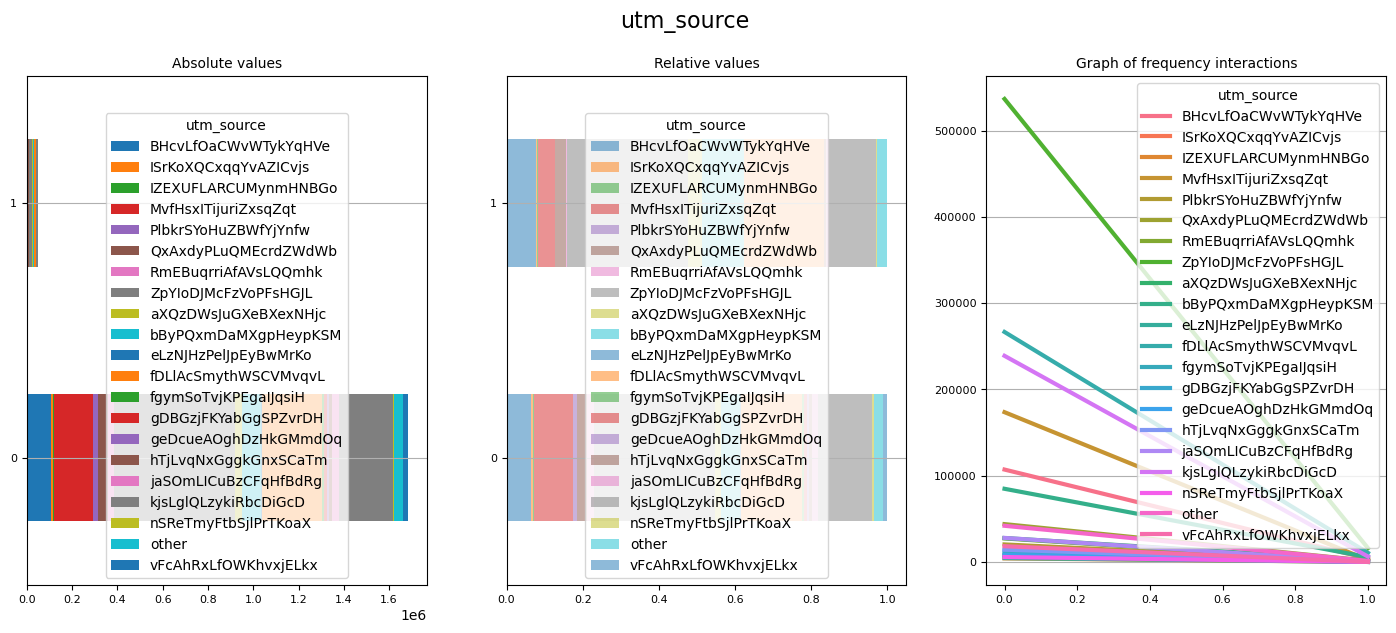


Absolute values:


utm_source,BHcvLfOaCWvWTykYqHVe,ISrKoXQCxqqYvAZICvjs,IZEXUFLARCUMynmHNBGo,MvfHsxITijuriZxsqZqt,PlbkrSYoHuZBWfYjYnfw,QxAxdyPLuQMEcrdZWdWb,RmEBuqrriAfAVsLQQmhk,ZpYIoDJMcFzVoPFsHGJL,aXQzDWsJuGXeBXexNHjc,bByPQxmDaMXgpHeypKSM,...,fgymSoTvjKPEgaIJqsiH,gDBGzjFKYabGgSPZvrDH,geDcueAOghDzHkGMmdOq,hTjLvqNxGggkGnxSCaTm,jaSOmLICuBzCFqHfBdRg,kjsLglQLzykiRbcDiGcD,nSReTmyFtbSjlPrTKoaX,other,vFcAhRxLfOWKhvxjELkx,sum
target,,,,,,,,,,,,,,,,,,,,,
0,107081,7698,4150,173582,20313,43863,27273,536557,27701,84799,...,9557,13329,8127,14219,27887,238885,5711,41925,18246,1681952
1,3882,141,98,2249,49,1404,139,15998,1827,5557,...,0,2,53,177,401,6293,104,1277,74,50314



Relative values:


utm_source,BHcvLfOaCWvWTykYqHVe,ISrKoXQCxqqYvAZICvjs,IZEXUFLARCUMynmHNBGo,MvfHsxITijuriZxsqZqt,PlbkrSYoHuZBWfYjYnfw,QxAxdyPLuQMEcrdZWdWb,RmEBuqrriAfAVsLQQmhk,ZpYIoDJMcFzVoPFsHGJL,aXQzDWsJuGXeBXexNHjc,bByPQxmDaMXgpHeypKSM,...,fgymSoTvjKPEgaIJqsiH,gDBGzjFKYabGgSPZvrDH,geDcueAOghDzHkGMmdOq,hTjLvqNxGggkGnxSCaTm,jaSOmLICuBzCFqHfBdRg,kjsLglQLzykiRbcDiGcD,nSReTmyFtbSjlPrTKoaX,other,vFcAhRxLfOWKhvxjELkx,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.063665,0.004577,0.002467,0.103203,0.012077,0.026079,0.016215,0.319009,0.016470,0.050417,...,0.005682,0.007925,0.004832,0.008454,0.01658,0.142028,0.003395,0.024926,0.010848,1.0
1,0.077155,0.002802,0.001948,0.044699,0.000974,0.027905,0.002763,0.317963,0.036312,0.110446,...,0.000000,0.000040,0.001053,0.003518,0.00797,0.125075,0.002067,0.025381,0.001471,1.0


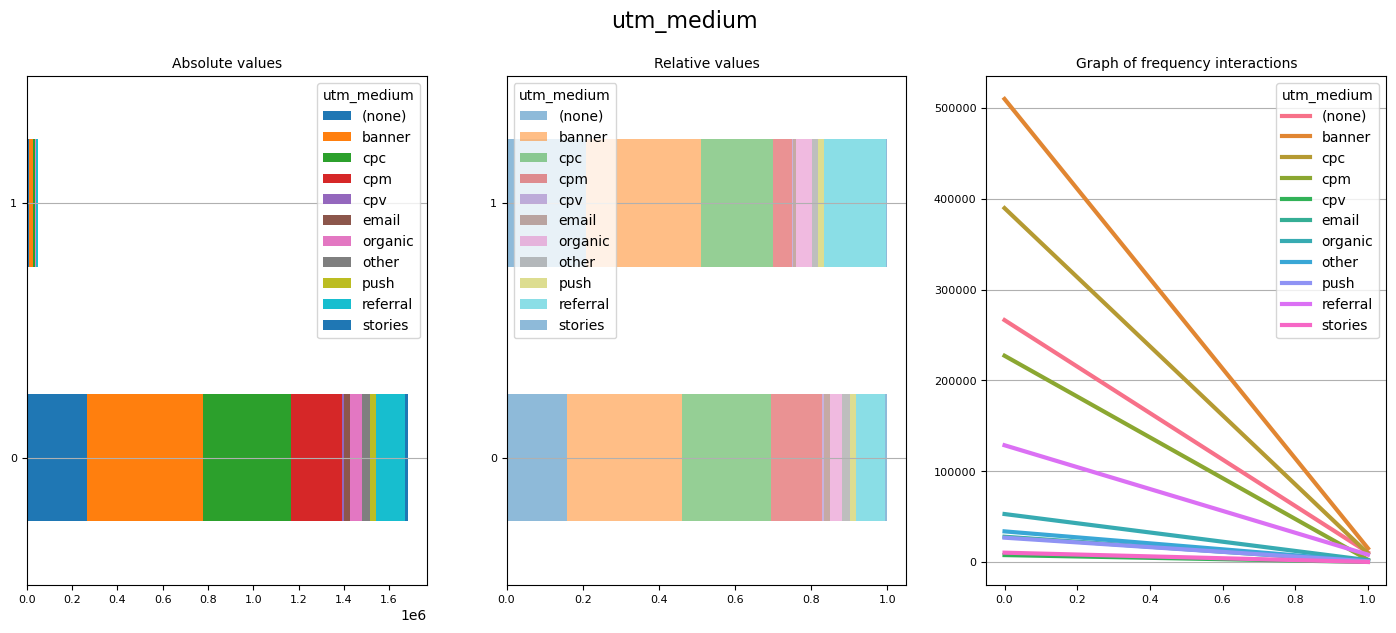


Absolute values:


utm_medium,(none),banner,cpc,cpm,cpv,email,organic,other,push,referral,stories,sum
target,,,,,,,,,,,,
0,266529,510099,389866,227272,7700,27886,52909,33805,26870,128670,10346,1681952
1,10531,15107,9529,2519,115,401,2100,865,840,8181,126,50314



Relative values:


utm_medium,(none),banner,cpc,cpm,cpv,email,organic,other,push,referral,stories,sum
target,,,,,,,,,,,,
0,0.158464,0.303278,0.231794,0.135124,0.004578,0.01658,0.031457,0.020099,0.015975,0.076500,0.006151,1.0
1,0.209306,0.300254,0.189391,0.050066,0.002286,0.00797,0.041738,0.017192,0.016695,0.162599,0.002504,1.0


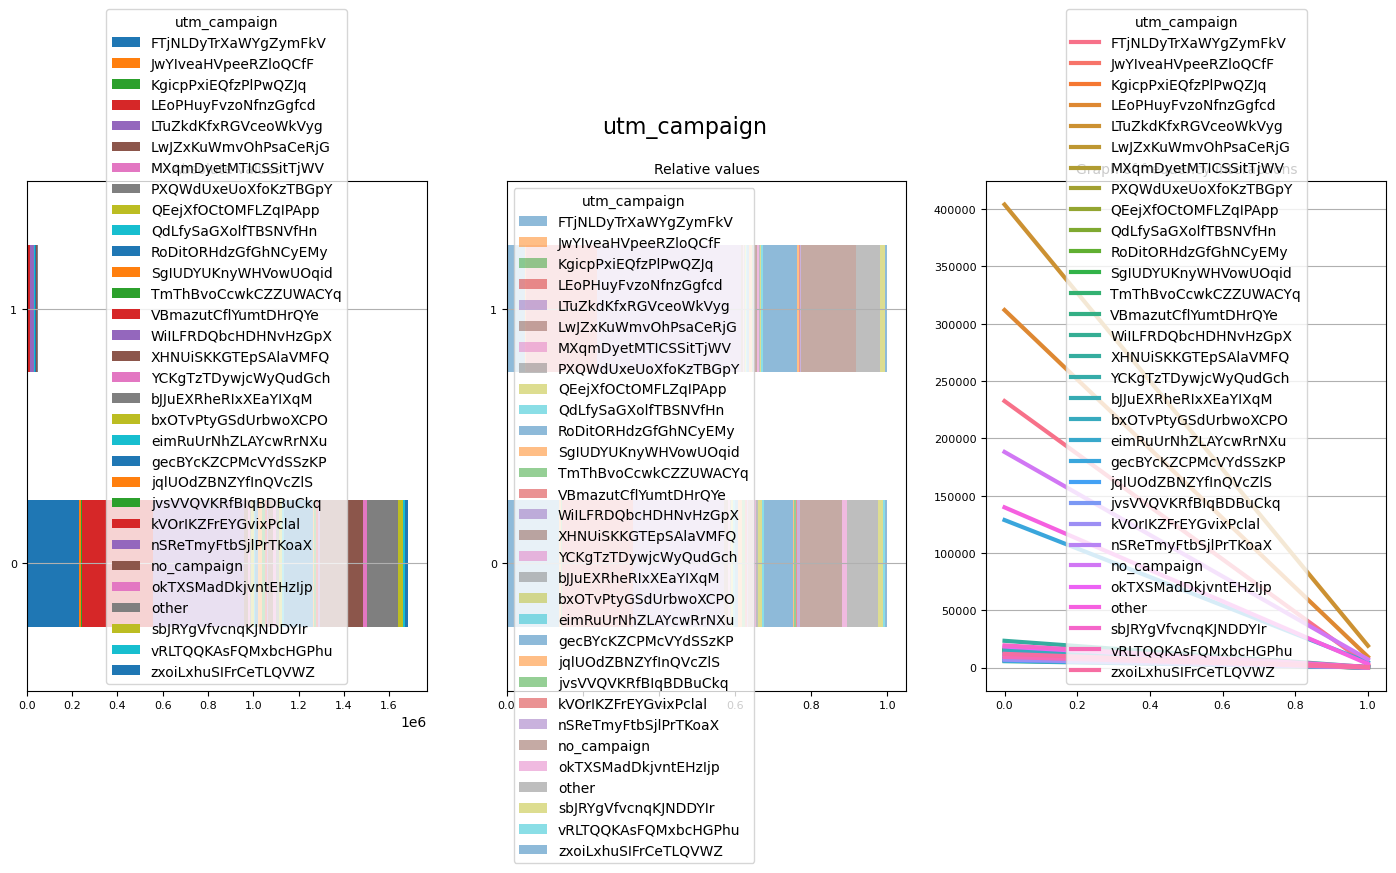


Absolute values:


utm_campaign,FTjNLDyTrXaWYgZymFkV,JwYIveaHVpeeRZloQCfF,KgicpPxiEQfzPlPwQZJq,LEoPHuyFvzoNfnzGgfcd,LTuZkdKfxRGVceoWkVyg,LwJZxKuWmvOhPsaCeRjG,MXqmDyetMTICSSitTjWV,PXQWdUxeUoXfoKzTBGpY,QEejXfOCtOMFLZqIPApp,QdLfySaGXolfTBSNVfHn,...,jvsVVQVKRfBIqBDBuCkq,kVOrIKZFrEYGvixPclal,nSReTmyFtbSjlPrTKoaX,no_campaign,okTXSMadDkjvntEHzIjp,other,sbJRYgVfvcnqKJNDDYIr,vRLTQQKAsFQMxbcHGPhu,zxoiLxhuSIFrCeTLQVWZ,sum
target,,,,,,,,,,,,,,,,,,,,,
0,232503,6246,6730,311938,403986,16561,6787,6717,9933,6694,...,7619,6864,11040,188113,18328,139788,19367,9240,11964,1681952
1,2447,128,28,9348,19006,285,157,112,134,151,...,102,30,232,7174,77,3181,575,79,270,50314



Relative values:


utm_campaign,FTjNLDyTrXaWYgZymFkV,JwYIveaHVpeeRZloQCfF,KgicpPxiEQfzPlPwQZJq,LEoPHuyFvzoNfnzGgfcd,LTuZkdKfxRGVceoWkVyg,LwJZxKuWmvOhPsaCeRjG,MXqmDyetMTICSSitTjWV,PXQWdUxeUoXfoKzTBGpY,QEejXfOCtOMFLZqIPApp,QdLfySaGXolfTBSNVfHn,...,jvsVVQVKRfBIqBDBuCkq,kVOrIKZFrEYGvixPclal,nSReTmyFtbSjlPrTKoaX,no_campaign,okTXSMadDkjvntEHzIjp,other,sbJRYgVfvcnqKJNDDYIr,vRLTQQKAsFQMxbcHGPhu,zxoiLxhuSIFrCeTLQVWZ,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.138234,0.003714,0.004001,0.185462,0.240189,0.009846,0.004035,0.003994,0.005906,0.003980,...,0.004530,0.004081,0.006564,0.111842,0.010897,0.083111,0.011515,0.005494,0.007113,1.0
1,0.048635,0.002544,0.000557,0.185793,0.377748,0.005664,0.003120,0.002226,0.002663,0.003001,...,0.002027,0.000596,0.004611,0.142585,0.001530,0.063223,0.011428,0.001570,0.005366,1.0


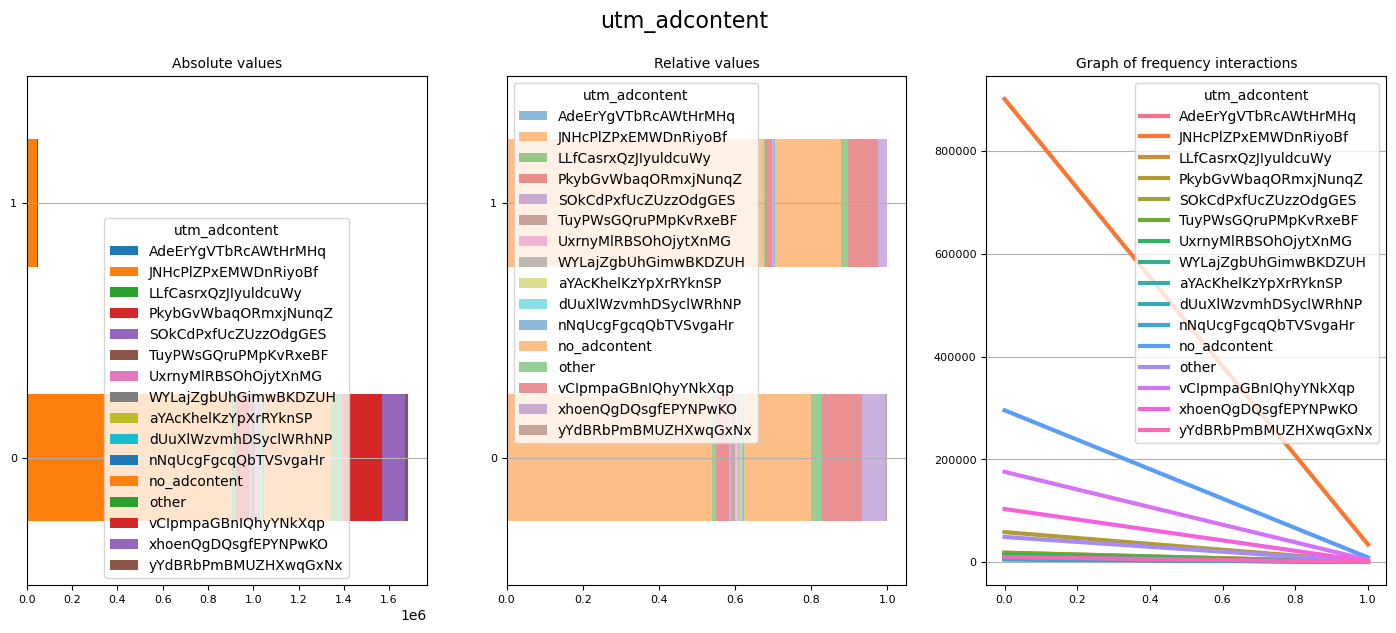


Absolute values:


utm_adcontent,AdeErYgVTbRcAWtHrMHq,JNHcPlZPxEMWDnRiyoBf,LLfCasrxQzJIyuldcuWy,PkybGvWbaqORmxjNunqZ,SOkCdPxfUcZUzzOdgGES,TuyPWsGQruPMpKvRxeBF,UxrnyMlRBSOhOjytXnMG,WYLajZgbUhGimwBKDZUH,aYAcKhelKzYpXrRYknSP,dUuXlWzvmhDSyclWRhNP,nNqUcgFgcqQbTVSvgaHr,no_adcontent,other,vCIpmpaGBnIQhyYNkXqp,xhoenQgDQsgfEPYNPwKO,yYdBRbPmBMUZHXwqGxNx,sum
target,,,,,,,,,,,,,,,,,
0,5474,901445,18066,58060,6520,17882,13347,8059,4905,9970,5926,295384,48651,175527,103109,9627,1681952
1,60,33963,72,978,151,2,2,51,27,55,74,8753,939,3911,1272,4,50314



Relative values:


utm_adcontent,AdeErYgVTbRcAWtHrMHq,JNHcPlZPxEMWDnRiyoBf,LLfCasrxQzJIyuldcuWy,PkybGvWbaqORmxjNunqZ,SOkCdPxfUcZUzzOdgGES,TuyPWsGQruPMpKvRxeBF,UxrnyMlRBSOhOjytXnMG,WYLajZgbUhGimwBKDZUH,aYAcKhelKzYpXrRYknSP,dUuXlWzvmhDSyclWRhNP,nNqUcgFgcqQbTVSvgaHr,no_adcontent,other,vCIpmpaGBnIQhyYNkXqp,xhoenQgDQsgfEPYNPwKO,yYdBRbPmBMUZHXwqGxNx,sum
target,,,,,,,,,,,,,,,,,
0,0.003255,0.535952,0.010741,0.034519,0.003876,0.010632,0.007935,0.004791,0.002916,0.005928,0.003523,0.175620,0.028925,0.104359,0.061303,0.005724,1.0
1,0.001193,0.675021,0.001431,0.019438,0.003001,0.000040,0.000040,0.001014,0.000537,0.001093,0.001471,0.173967,0.018663,0.077732,0.025281,0.000080,1.0


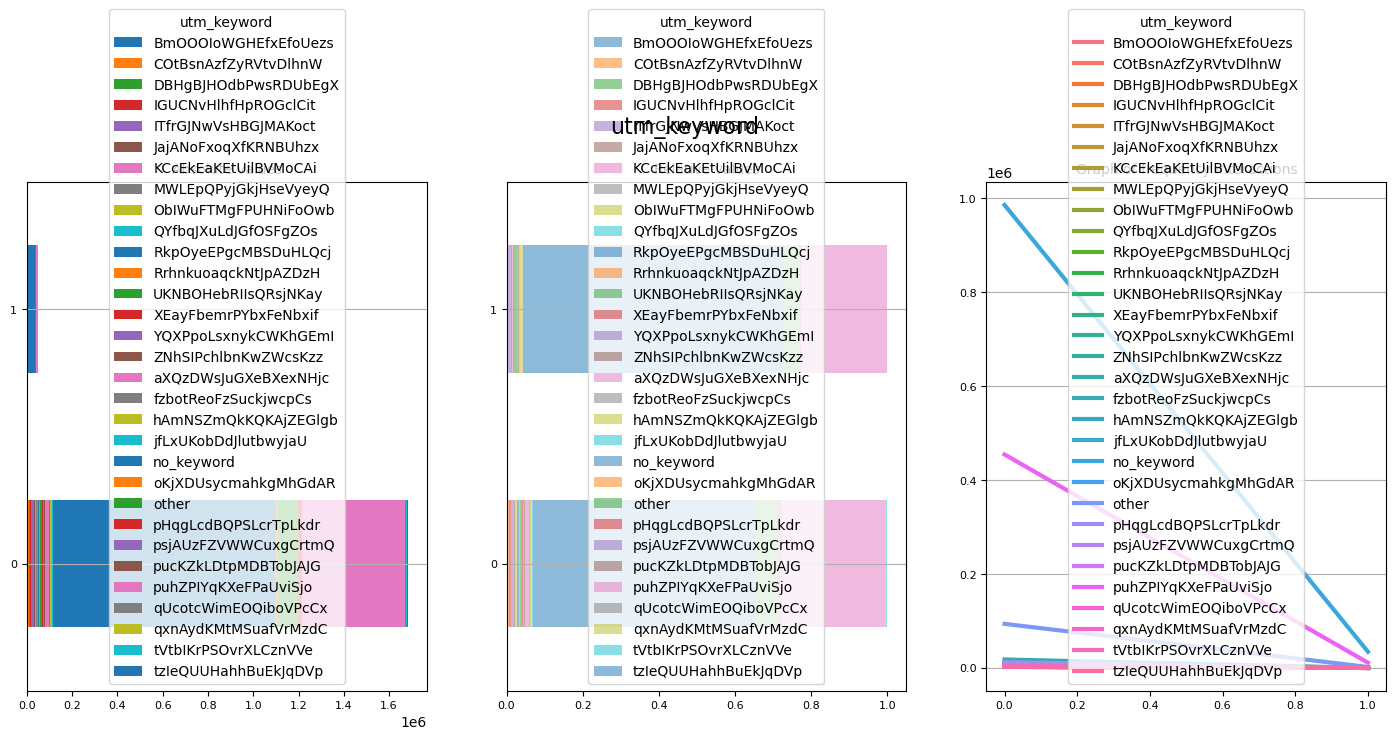


Absolute values:


utm_keyword,BmOOOIoWGHEfxEfoUezs,COtBsnAzfZyRVtvDlhnW,DBHgBJHOdbPwsRDUbEgX,IGUCNvHlhfHpROGclCit,ITfrGJNwVsHBGJMAKoct,JajANoFxoqXfKRNBUhzx,KCcEkEaKEtUilBVMoCAi,MWLEpQPyjGkjHseVyeyQ,ObIWuFTMgFPUHNiFoOwb,QYfbqJXuLdJGfOSFgZOs,...,other,pHqgLcdBQPSLcrTpLkdr,psjAUzFZVWWCuxgCrtmQ,pucKZkLDtpMDBTobJAJG,puhZPIYqKXeFPaUviSjo,qUcotcWimEOQiboVPcCx,qxnAydKMtMSuafVrMzdC,tVtbIKrPSOvrXLCznVVe,tzIeQUUHahhBuEkJqDVp,sum
target,,,,,,,,,,,,,,,,,,,,,
0,5972,2512,4033,6843,12073,6116,2405,2853,2471,2436,...,93954,12208,2348,4523,454765,2371,2360,3426,2589,1681952
1,50,51,40,107,322,159,56,28,0,48,...,2106,112,47,59,11185,0,20,67,13,50314



Relative values:


utm_keyword,BmOOOIoWGHEfxEfoUezs,COtBsnAzfZyRVtvDlhnW,DBHgBJHOdbPwsRDUbEgX,IGUCNvHlhfHpROGclCit,ITfrGJNwVsHBGJMAKoct,JajANoFxoqXfKRNBUhzx,KCcEkEaKEtUilBVMoCAi,MWLEpQPyjGkjHseVyeyQ,ObIWuFTMgFPUHNiFoOwb,QYfbqJXuLdJGfOSFgZOs,...,other,pHqgLcdBQPSLcrTpLkdr,psjAUzFZVWWCuxgCrtmQ,pucKZkLDtpMDBTobJAJG,puhZPIYqKXeFPaUviSjo,qUcotcWimEOQiboVPcCx,qxnAydKMtMSuafVrMzdC,tVtbIKrPSOvrXLCznVVe,tzIeQUUHahhBuEkJqDVp,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.003551,0.001494,0.002398,0.004068,0.007178,0.003636,0.001430,0.001696,0.001469,0.001448,...,0.055860,0.007258,0.001396,0.002689,0.270379,0.00141,0.001403,0.002037,0.001539,1.0
1,0.000994,0.001014,0.000795,0.002127,0.006400,0.003160,0.001113,0.000557,0.000000,0.000954,...,0.041857,0.002226,0.000934,0.001173,0.222304,0.00000,0.000398,0.001332,0.000258,1.0


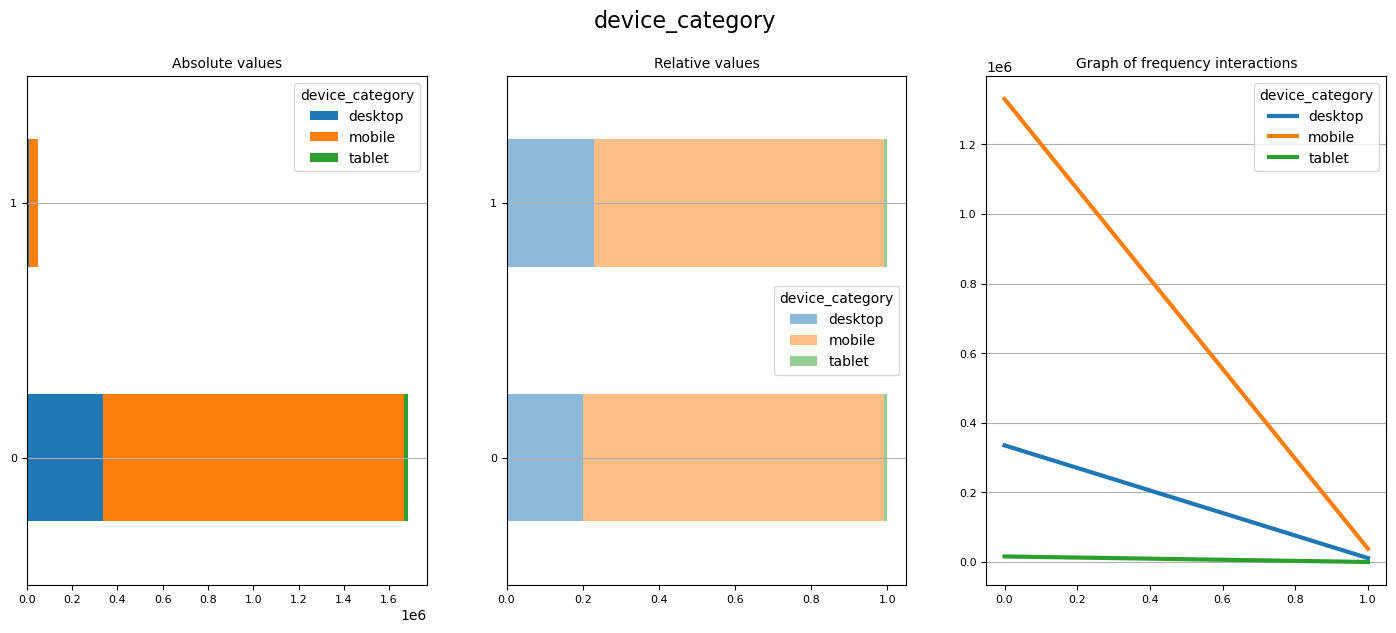


Absolute values:


device_category,desktop,mobile,tablet,sum
target,,,,
0,335378,1330300,16274,1681952
1,11513,38379,422,50314



Relative values:


device_category,desktop,mobile,tablet,sum
target,,,,
0,0.199398,0.790926,0.009676,1.0
1,0.228823,0.762790,0.008387,1.0


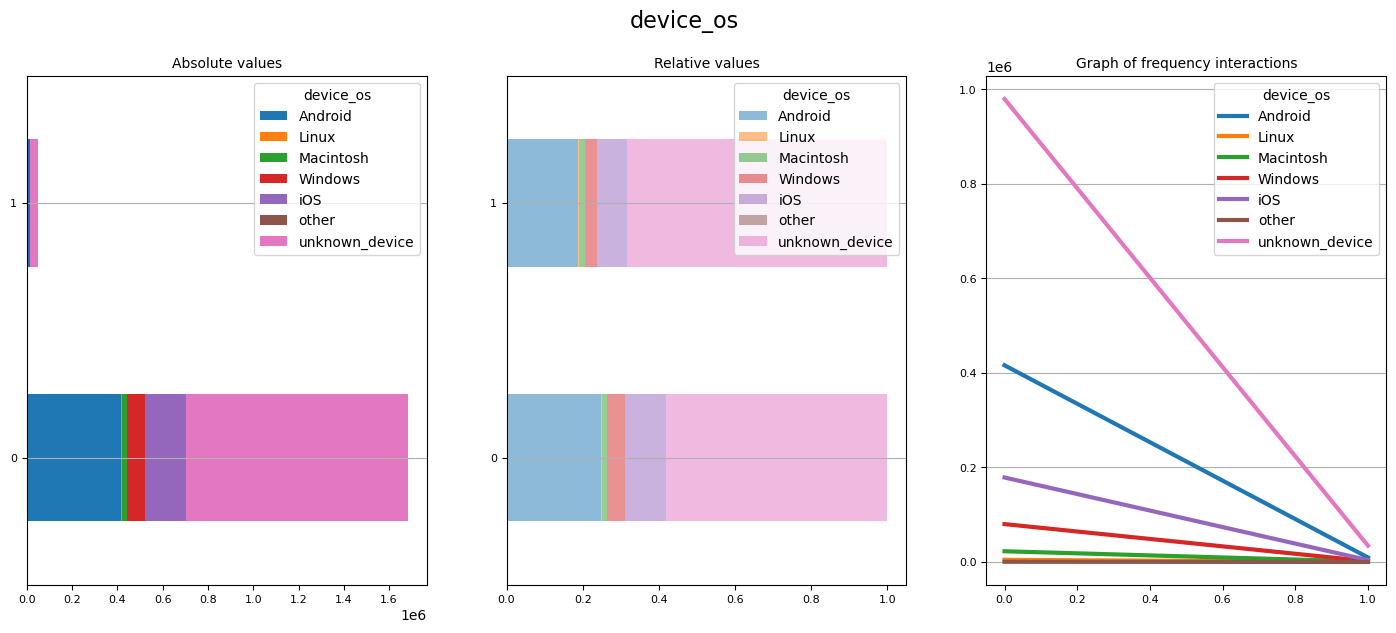


Absolute values:


device_os,Android,Linux,Macintosh,Windows,iOS,other,unknown_device,sum
target,,,,,,,,
0,416057,4526,22643,80107,178678,414,979527,1681952
1,9463,90,772,1633,3919,0,34437,50314



Relative values:


device_os,Android,Linux,Macintosh,Windows,iOS,other,unknown_device,sum
target,,,,,,,,
0,0.247366,0.002691,0.013462,0.047627,0.106233,0.000246,0.582375,1.0
1,0.188079,0.001789,0.015344,0.032456,0.077891,0.000000,0.684442,1.0


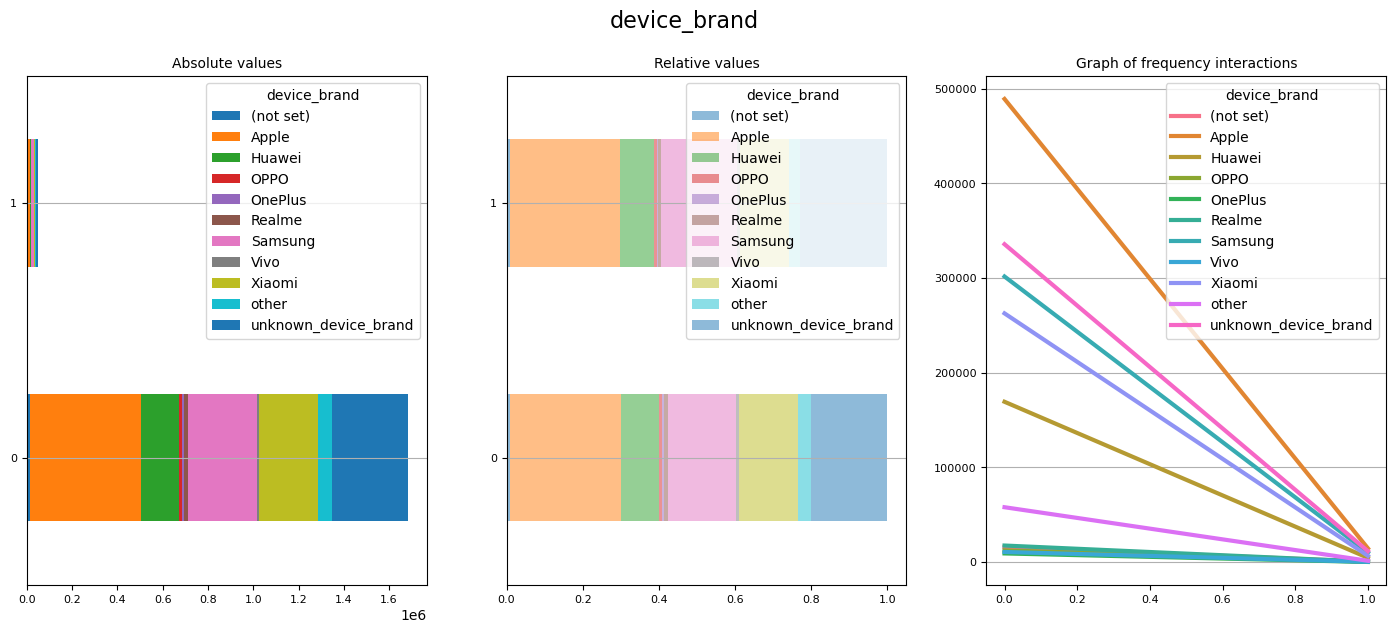


Absolute values:


device_brand,(not set),Apple,Huawei,OPPO,OnePlus,Realme,Samsung,Vivo,Xiaomi,other,unknown_device_brand,sum
target,,,,,,,,,,,,
0,15938,489066,169309,12379,9165,17505,301587,10704,262659,57962,335678,1681952
1,454,14467,4519,396,157,421,10054,322,6592,1414,11518,50314



Relative values:


device_brand,(not set),Apple,Huawei,OPPO,OnePlus,Realme,Samsung,Vivo,Xiaomi,other,unknown_device_brand,sum
target,,,,,,,,,,,,
0,0.009476,0.290773,0.100662,0.007360,0.005449,0.010408,0.179308,0.006364,0.156163,0.034461,0.199576,1.0
1,0.009023,0.287534,0.089816,0.007871,0.003120,0.008367,0.199825,0.006400,0.131017,0.028104,0.228922,1.0


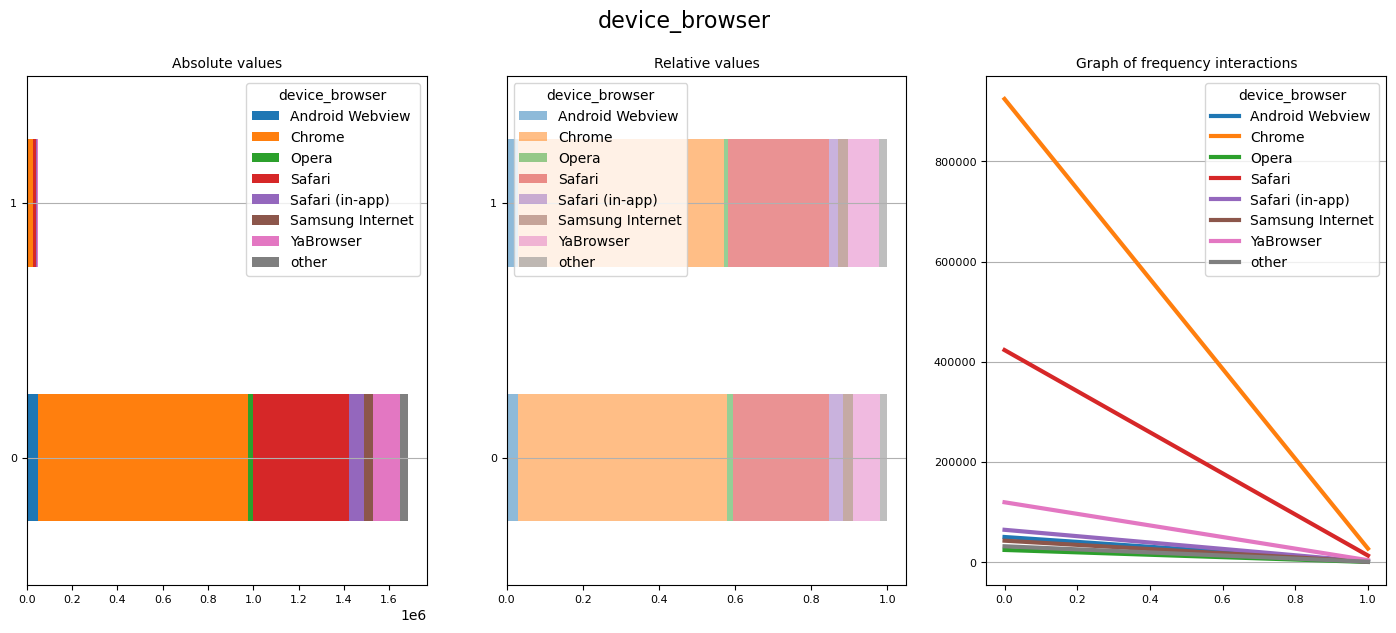


Absolute values:


device_browser,Android Webview,Chrome,Opera,Safari,Safari (in-app),Samsung Internet,YaBrowser,other,sum
target,,,,,,,,,
0,50364,924385,24533,423382,64731,43016,119679,31862,1681952
1,1555,27188,561,13323,1221,1257,4086,1123,50314



Relative values:


device_browser,Android Webview,Chrome,Opera,Safari,Safari (in-app),Samsung Internet,YaBrowser,other,sum
target,,,,,,,,,
0,0.029944,0.549591,0.014586,0.251721,0.038486,0.025575,0.071155,0.018943,1.0
1,0.030906,0.540366,0.011150,0.264797,0.024268,0.024983,0.081210,0.022320,1.0


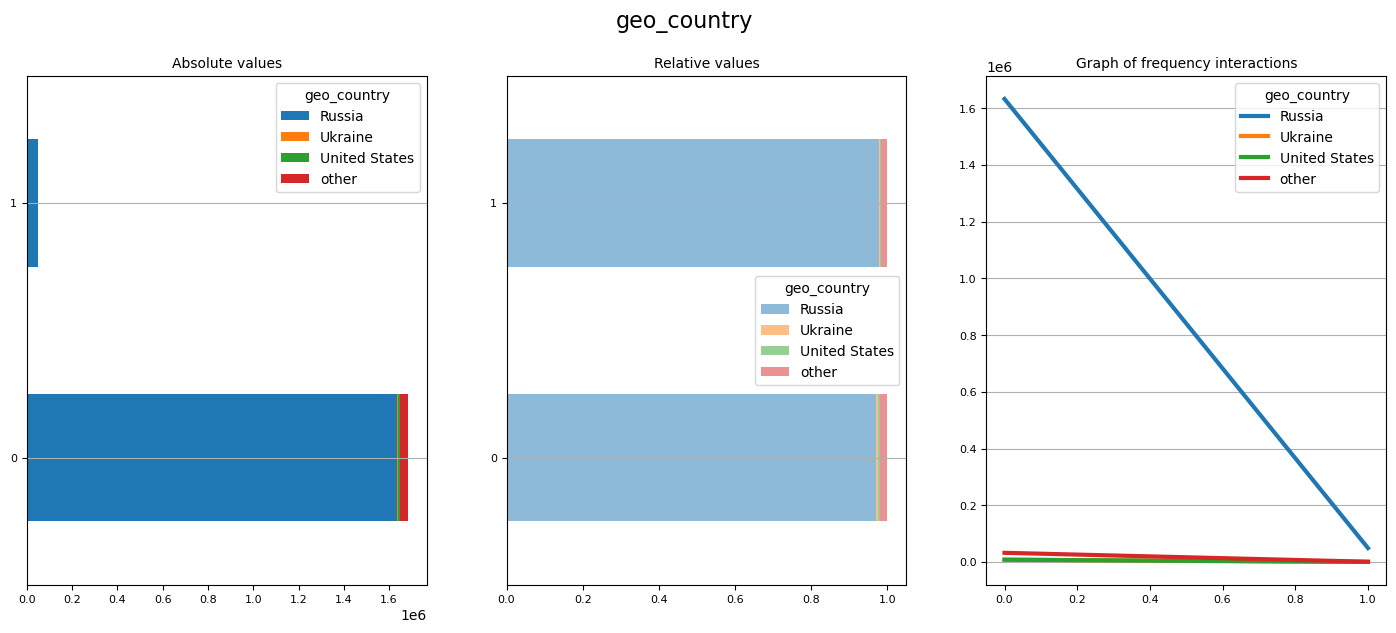


Absolute values:


geo_country,Russia,Ukraine,United States,other,sum
target,,,,,
0,1633267,8256,8077,32352,1681952
1,49156,199,64,895,50314



Relative values:


geo_country,Russia,Ukraine,United States,other,sum
target,,,,,
0,0.971054,0.004909,0.004802,0.019235,1.0
1,0.976985,0.003955,0.001272,0.017788,1.0


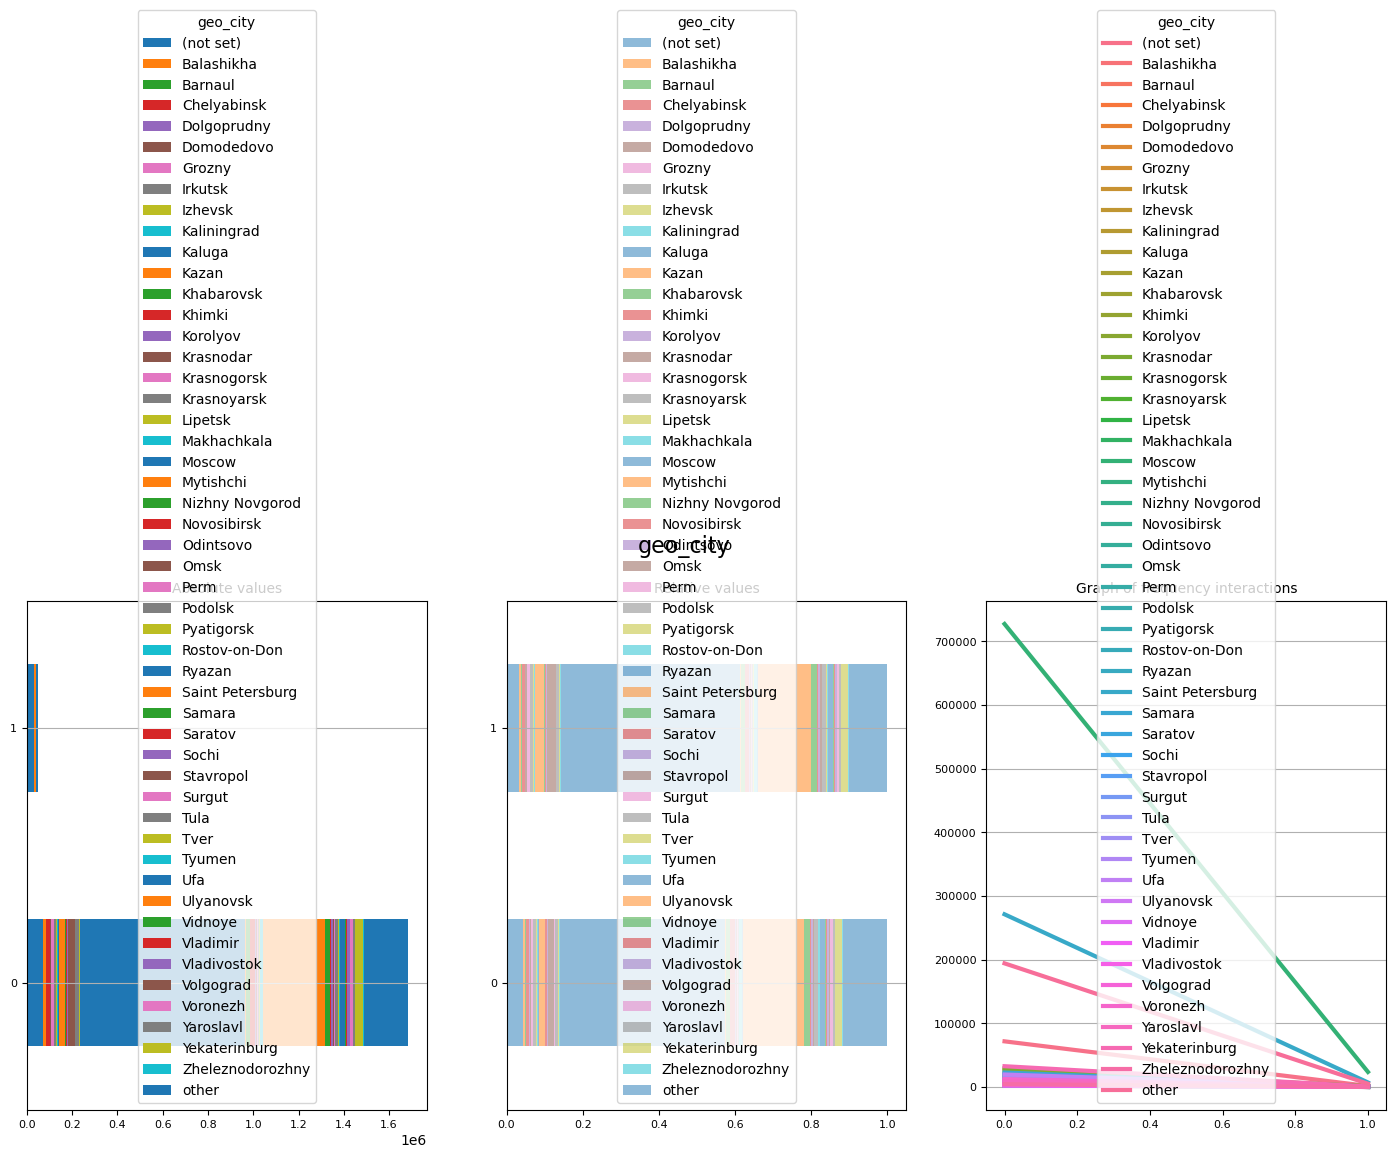


Absolute values:


geo_city,(not set),Balashikha,Barnaul,Chelyabinsk,Dolgoprudny,Domodedovo,Grozny,Irkutsk,Izhevsk,Kaliningrad,...,Vidnoye,Vladimir,Vladivostok,Volgograd,Voronezh,Yaroslavl,Yekaterinburg,Zheleznodorozhny,other,sum
target,,,,,,,,,,,,,,,,,,,,,
0,71709,11509,2660,14526,2452,3466,11548,12269,4748,3473,...,4914,2334,11265,3630,12419,8905,32668,4506,194218,1681952
1,1588,359,59,397,86,263,401,327,123,99,...,144,86,249,88,282,238,887,103,5100,50314



Relative values:


geo_city,(not set),Balashikha,Barnaul,Chelyabinsk,Dolgoprudny,Domodedovo,Grozny,Irkutsk,Izhevsk,Kaliningrad,...,Vidnoye,Vladimir,Vladivostok,Volgograd,Voronezh,Yaroslavl,Yekaterinburg,Zheleznodorozhny,other,sum
target,,,,,,,,,,,,,,,,,,,,,
0,0.042634,0.006843,0.001581,0.008636,0.001458,0.002061,0.006866,0.007295,0.002823,0.002065,...,0.002922,0.001388,0.006698,0.002158,0.007384,0.005294,0.019423,0.002679,0.115472,1.0
1,0.031562,0.007135,0.001173,0.007890,0.001709,0.005227,0.007970,0.006499,0.002445,0.001968,...,0.002862,0.001709,0.004949,0.001749,0.005605,0.004730,0.017629,0.002047,0.101363,1.0


In [16]:
for col in cat_cols:
    pivot = df.pivot_table(
    values='session_id',
    index='target',
    columns=col,
    aggfunc='count',
    fill_value=0,
    margins=True)

    pivot = pivot.iloc[:-1,:-1]
    
    graph_contingency_tables_bar_freqint(
    data_df_in=pivot,
    graph_inclusion='arf',
    title_figure = col, title_figure_fontsize = 16,
    result_output=True,
    tight_layout=False,
    graph_size=(297/INCH*1.5, 210/INCH/1.25)
    )


In [17]:
X = df.drop(['target'], axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

random_state=42

In [18]:
vc =  y_train.value_counts()

disbalance = vc[1]/vc[0]
print('disbalance:',disbalance)

disbalance: 0.029871614799810178


In [19]:
OverS = RandomOverSampler(random_state=42)

X_Over, Y_Over = OverS.fit_resample(X_train, y_train)
df_over = X_Over.copy()
df_over['target'] = Y_Over

In [20]:
# for col in cat_cols:
#     pivot = df_over.pivot_table(
#     values='session_id',
#     index='target',
#     columns=col,
#     aggfunc='count',
#     fill_value=0,
#     margins=True)

#     pivot = pivot.iloc[:-1,:-1]
    
#     graph_contingency_tables_bar_freqint(
#     data_df_in=pivot,
#     graph_inclusion='af',
#     title_figure = col, title_figure_fontsize = 16,
#     result_output=True,
#     tight_layout=False,
#     graph_size=(297/INCH*1.5, 210/INCH/1.25)
#     )


In [21]:
    # df_over.loc[~df_over['utm_source'].isin(df['utm_source'].value_counts().head(10).index),'utm_source'] = 'other'
    # df_over.loc[~df_over['utm_campaign'].isin(df['utm_campaign'].value_counts().head(7).index),'utm_campaign'] = 'other'
    # df_over.loc[~df_over['utm_keyword'].isin(df['utm_keyword'].value_counts().head(3).index),'utm_keyword'] = 'other'
    # df_over.loc[~df_over['device_brand'].isin(df['device_brand'].value_counts().head(6).index),'device_brand'] = 'other'
    # df_over.loc[~df_over['geo_city'].isin(df['geo_city'].value_counts().head(5).index),'geo_city'] = 'other'

    # del df_over['geo_country']

    # cat_cols = list(cat_cols)

    # cat_cols.pop(-2)

    # numerical = df_over.select_dtypes('number').drop(columns='target')
    # categorical = df_over.select_dtypes('object').drop(columns='session_id')

    # scaler = MinMaxScaler()

    # for col in numerical.columns:

    #     df_over[col] = scaler.fit_transform(df_over[[col]])


    # to_encode = categorical.columns

    # ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    # ohe.fit(df_over[to_encode])

    # df_over[ohe.get_feature_names_out()] = ohe.transform(df_over[to_encode])

    # df_over = df_over.drop(columns=categorical.columns).drop(columns='session_id')



In [22]:
def data_transform(data):
    cat_cols = data.select_dtypes('object').drop(columns='session_id').columns
    data.loc[~data['utm_source'].isin(df['utm_source'].value_counts().head(10).index),'utm_source'] = 'other'
    data.loc[~data['utm_campaign'].isin(df['utm_campaign'].value_counts().head(7).index),'utm_campaign'] = 'other'
    data.loc[~data['utm_keyword'].isin(df['utm_keyword'].value_counts().head(3).index),'utm_keyword'] = 'other'
    data.loc[~data['device_brand'].isin(df['device_brand'].value_counts().head(6).index),'device_brand'] = 'other'
    data.loc[~data['geo_city'].isin(df['geo_city'].value_counts().head(5).index),'geo_city'] = 'other'

    del data['geo_country']

    cat_cols = list(cat_cols)

    cat_cols.pop(-2)

    numerical = data.select_dtypes('number').drop(columns='target')
    categorical = data.select_dtypes('object').drop(columns='session_id')

    scaler = MinMaxScaler()

    for col in numerical.columns:

        data[col] = scaler.fit_transform(data[[col]])


    to_encode = categorical.columns

    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    ohe.fit(data[to_encode])

    data[ohe.get_feature_names_out()] = ohe.transform(data[to_encode])

    data = data.drop(columns=categorical.columns).drop(columns='session_id')

    return data



In [23]:
df_over = data_transform(df_over)

In [24]:
df_ml = df_over.copy()

In [25]:
X_train = df_ml.drop(['target'], axis=1)
y_train = df_ml['target']
df_valid = X_valid.copy()
df_valid['target'] = y_valid

In [26]:
df_valid.loc[~df_valid['utm_source'].isin(df['utm_source'].value_counts().head(10).index),'utm_source'] = 'other'
df_valid.loc[~df_valid['utm_campaign'].isin(df['utm_campaign'].value_counts().head(7).index),'utm_campaign'] = 'other'
df_valid.loc[~df_valid['utm_keyword'].isin(df['utm_keyword'].value_counts().head(3).index),'utm_keyword'] = 'other'
df_valid.loc[~df_valid['device_brand'].isin(df['device_brand'].value_counts().head(6).index),'device_brand'] = 'other'
df_valid.loc[~df_valid['geo_city'].isin(df['geo_city'].value_counts().head(5).index),'geo_city'] = 'other'

del df_valid['geo_country']

numerical = df_valid.select_dtypes('number').drop(columns='target')
categorical = df_valid.select_dtypes('object').drop(columns='session_id')

scaler = MinMaxScaler()

for col in numerical.columns:

    df_valid[col] = scaler.fit_transform(df_valid[[col]])


to_encode = categorical.columns

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(df_valid[to_encode])

df_valid[ohe.get_feature_names_out()] = ohe.transform(df_valid[to_encode])

df_valid = df_valid.drop(columns=categorical.columns).drop(columns='session_id')

In [27]:
y_valid = df_valid['target']
X_valid = df_valid.drop(columns='target')

In [28]:
from catboost import CatBoostClassifier



# Создание и обучение модели CatBoost
cbc = CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, random_state=42)
cbc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = cbc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


0:	learn: 0.6849495	total: 106ms	remaining: 10.5s
1:	learn: 0.6783120	total: 162ms	remaining: 7.95s
2:	learn: 0.6730575	total: 221ms	remaining: 7.16s
3:	learn: 0.6689781	total: 275ms	remaining: 6.6s
4:	learn: 0.6648504	total: 334ms	remaining: 6.34s
5:	learn: 0.6618337	total: 393ms	remaining: 6.16s
6:	learn: 0.6592188	total: 470ms	remaining: 6.25s
7:	learn: 0.6571777	total: 530ms	remaining: 6.09s
8:	learn: 0.6551097	total: 593ms	remaining: 6s
9:	learn: 0.6536115	total: 652ms	remaining: 5.87s
10:	learn: 0.6515814	total: 711ms	remaining: 5.75s
11:	learn: 0.6504159	total: 767ms	remaining: 5.62s
12:	learn: 0.6491792	total: 825ms	remaining: 5.52s
13:	learn: 0.6478997	total: 884ms	remaining: 5.43s
14:	learn: 0.6471163	total: 943ms	remaining: 5.34s
15:	learn: 0.6462076	total: 1s	remaining: 5.25s
16:	learn: 0.6454624	total: 1.05s	remaining: 5.14s
17:	learn: 0.6445915	total: 1.11s	remaining: 5.08s
18:	learn: 0.6438511	total: 1.17s	remaining: 5s
19:	learn: 0.6432590	total: 1.23s	remaining: 4.93s


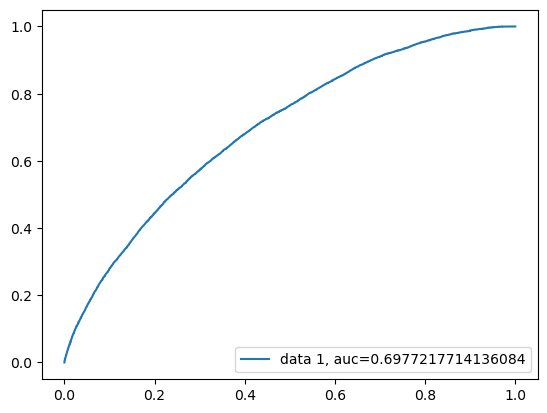

In [29]:

y_valid_proba = cbc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [30]:
from xgboost import XGBClassifier


# Создание и обучение модели XGBoost
xc = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = xc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.60


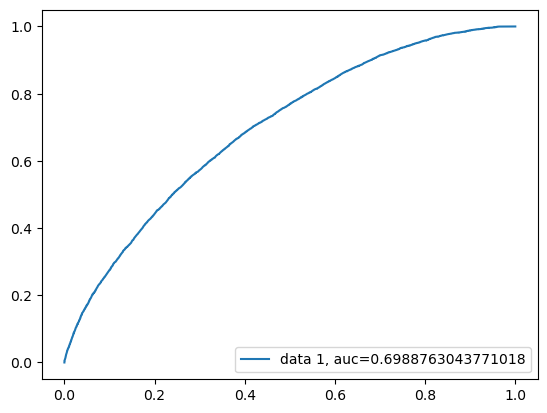

In [31]:
y_valid_proba = xc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [32]:
from lightgbm import LGBMClassifier


# Создание и обучение модели LightGBM
lc = LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
lc.fit(X_train, y_train)

# Оценка качества модели на тестовой выборке
accuracy = lc.score(X_valid, y_valid)
print(f"Accuracy: {accuracy:.2f}")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Accuracy: 0.59


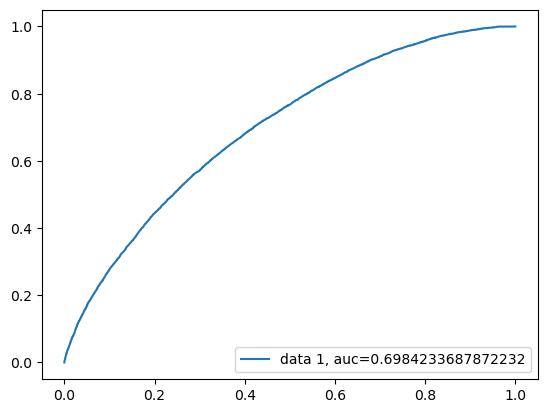

In [33]:
y_valid_proba = lc.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [34]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train,y_train)
predicted_train = gnb.predict(X_train)
predicted_valid = gnb.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))


0.5485789298791525 0.1640744192183673


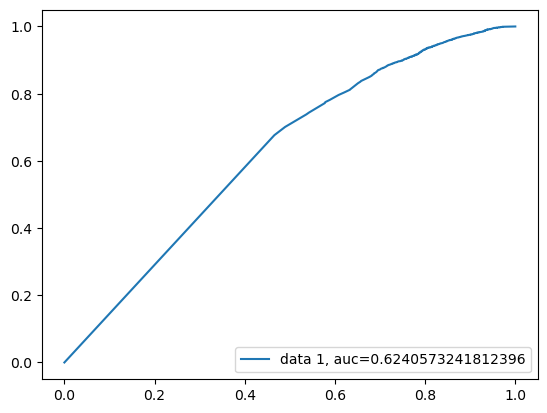

In [35]:
y_valid_proba = gnb.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [36]:
log = LogisticRegression()
log.fit(X_train,y_train)
predicted_train = log.predict(X_train)
predicted_valid = log.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))

0.6240611042634758 0.5629808921399648


/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


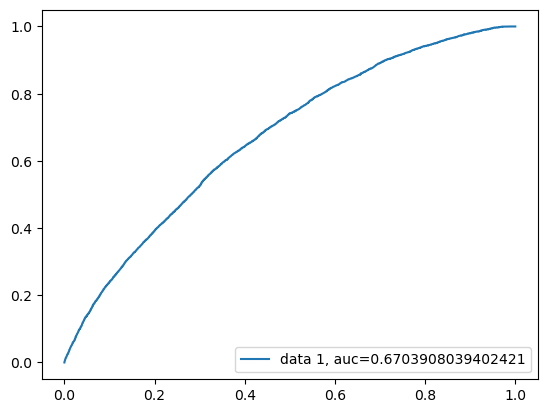

In [37]:
y_valid_proba = log.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [38]:
rf = RandomForestClassifier(random_state=43)
rf.fit(X_train,y_train)
predicted_train = rf.predict(X_train)
predicted_valid = rf.predict(X_valid)

print(accuracy_score(y_train,predicted_train), accuracy_score(y_valid,predicted_valid))




0.8987696551021254 0.81862377225608


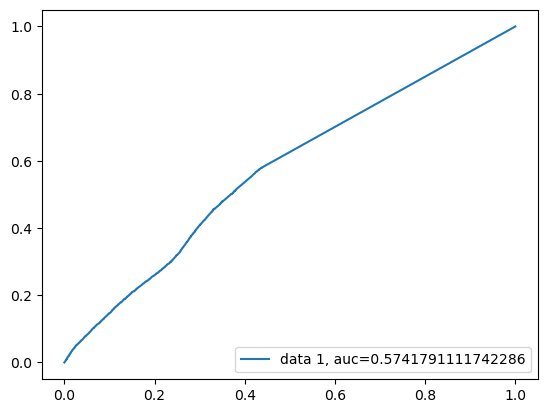

In [39]:
y_valid_proba = rf.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [40]:
from sklearn.calibration import CalibrationDisplay


clf_list = [
    (log, "Logistic Regression"),
    (gnb, "Naive Bayes"),
    (cbc, "CatBoostClassifier"),
    (lc,'LGBMClassifier'),
    (rf, "Random forest"),
    (xc, "XGBClassifier"),
]

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword 

0:	learn: 0.6849495	total: 52.9ms	remaining: 5.23s
1:	learn: 0.6783120	total: 110ms	remaining: 5.41s
2:	learn: 0.6730575	total: 166ms	remaining: 5.38s
3:	learn: 0.6689781	total: 216ms	remaining: 5.19s
4:	learn: 0.6648504	total: 274ms	remaining: 5.2s
5:	learn: 0.6618337	total: 326ms	remaining: 5.11s
6:	learn: 0.6592188	total: 380ms	remaining: 5.04s
7:	learn: 0.6571777	total: 435ms	remaining: 5s
8:	learn: 0.6551097	total: 492ms	remaining: 4.98s
9:	learn: 0.6536115	total: 548ms	remaining: 4.93s
10:	learn: 0.6515814	total: 601ms	remaining: 4.86s
11:	learn: 0.6504159	total: 657ms	remaining: 4.82s
12:	learn: 0.6491792	total: 712ms	remaining: 4.76s
13:	learn: 0.6478997	total: 766ms	remaining: 4.71s
14:	learn: 0.6471163	total: 820ms	remaining: 4.65s
15:	learn: 0.6462076	total: 873ms	remaining: 4.58s
16:	learn: 0.6454624	total: 923ms	remaining: 4.51s
17:	learn: 0.6445915	total: 980ms	remaining: 4.46s
18:	learn: 0.6438511	total: 1.03s	remaining: 4.41s
19:	learn: 0.6432590	total: 1.09s	remaining:

/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/home/alexander/anaconda3/lib/python3.11/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]


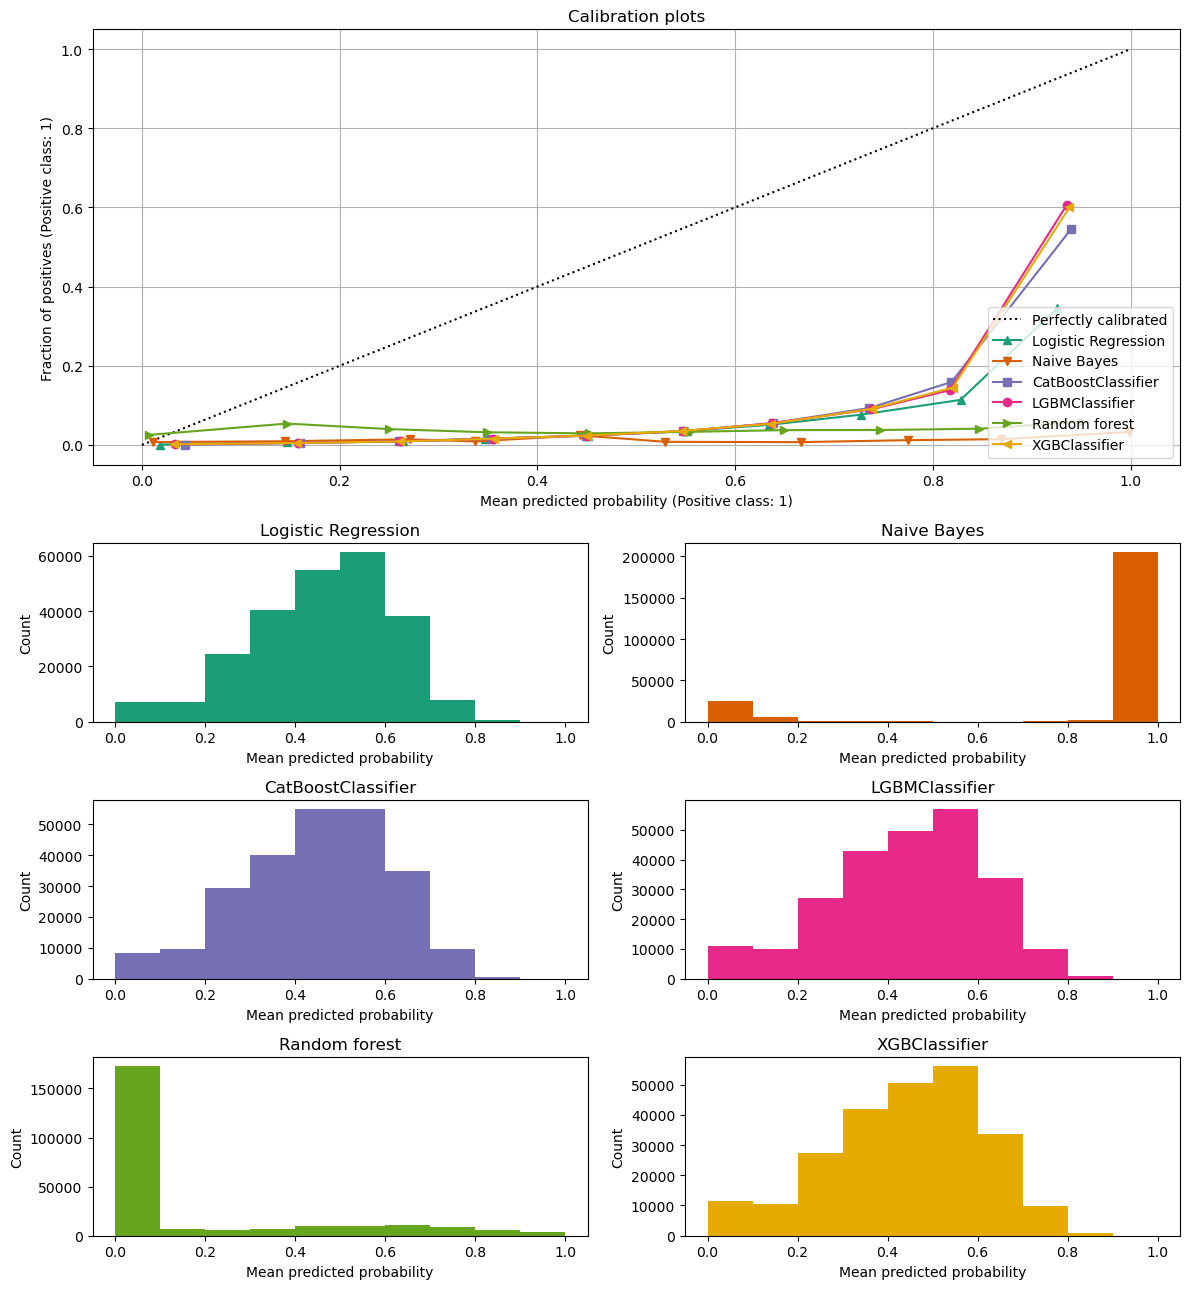

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibrationDisplay
import math

# Предполагается, что clf_list уже определен
n_classifiers = len(clf_list)

# Рассчитываем количество строк для гистограмм
n_hist_rows = math.ceil(n_classifiers / 2)

fig = plt.figure(figsize=(12, 4 + 3 * n_hist_rows))
gs = GridSpec(2 + n_hist_rows, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :])
calibration_displays = {}
markers = ["^", "v", "s", "o", '>', '<', 'D', 'p', '*', 'h', 'H', '+', 'x', 'd', '|', '_']

# Убедитесь, что у вас достаточно маркеров для всех классификаторов
if n_classifiers > len(markers):
    markers = markers * (n_classifiers // len(markers) + 1)

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_valid,
        y_valid,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i % colors.N),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histograms
for i, (_, name) in enumerate(clf_list):
    row = 2 + i // 2
    col = i % 2
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i % colors.N),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()


In [42]:

clf_list = [
    # (log, "Logistic Regression"),
    # (gnb, "Naive Bayes"),
    # (cbc, "CatBoostClassifier"),
    (lc,'LGBMClassifier'),
    # (rf, "Random forest"),
    (xc, "XGBClassifier"),
]

In [43]:
clf_list_r = [(x[1],x[0]) for x in clf_list]

In [44]:
eclf1 = VotingClassifier(estimators=clf_list_r, voting='soft')

eclf1 = eclf1.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


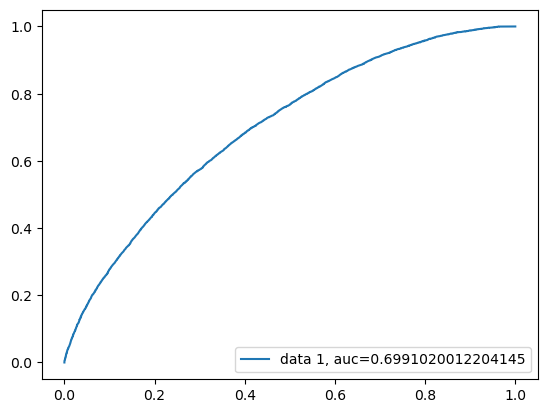

In [45]:



y_valid_proba = eclf1.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [46]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import GradientBoostingClassifier
# Создаем мета-модель
final_estimator = GradientBoostingClassifier()

# Создаем StackingClassifier
SC = StackingClassifier(estimators=clf_list_r, final_estimator=final_estimator)

# Обучаем модель
SC.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 941931, number of negative: 941931
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033589 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 1883862, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 753545, number of negative: 753544
[LightGBM] [Info] Auto-choosing row-

StackingClassifier(estimators=[('LGBMClassifier',
                                LGBMClassifier(max_depth=6, random_state=42)),
                               ('XGBClassifier',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gro...
                                              interaction_constraints=None,
                                              learning_rate=0.1, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=6,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...))],
                   final_estimator=GradientBoostingClassifier())

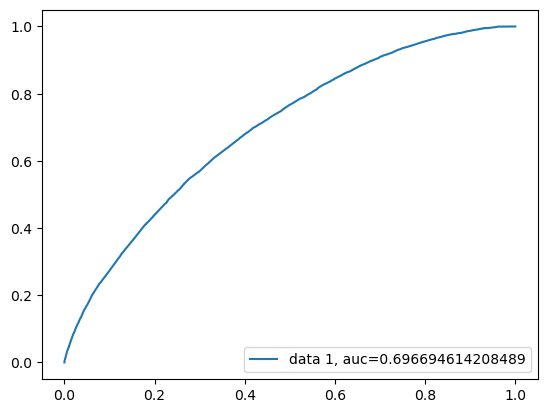

In [47]:
y_valid_proba = SC.predict_proba(X_valid)[::,1]
fpr, tpr, _ = roc_curve(y_valid,  y_valid_proba)
auc = roc_auc_score(y_valid, y_valid_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


* X_test

In [48]:
X_test_ini = X_test.copy()
df_test = X_test_ini.copy()
df_test['target'] = y_test

In [49]:
df_test = data_transform(df_test)

In [52]:
df_test['target'] = y_test

In [55]:
df_test['target'] = y_test

In [58]:
df_test

37140      0
1125067    0
987812     0
914381     0
85680      0
          ..
1263030    0
205550     0
1324479    0
988305     0
882383     0
Name: target, Length: 519680, dtype: int64

In [61]:
X_test = df_test.drop(columns='target')
y_test = df_test['target']

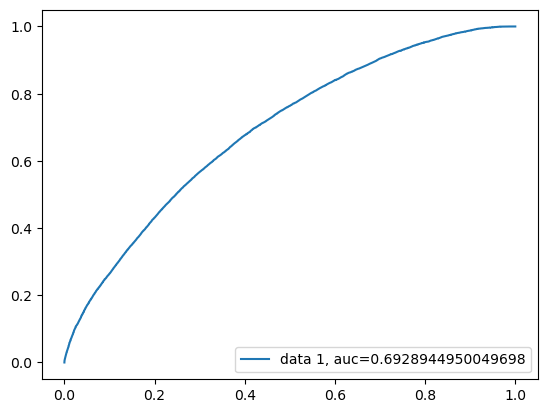

In [63]:

y_test_proba = eclf1.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()


In [ ]:
X_test.shape

(519680, 15)

In [ ]:
X_valid.shape

(242518, 79)

In [ ]:
X_valid

,visit_time,visit_number,screen_square,utm_source_BHcvLfOaCWvWTykYqHVe,utm_source_MvfHsxITijuriZxsqZqt,utm_source_QxAxdyPLuQMEcrdZWdWb,utm_source_ZpYIoDJMcFzVoPFsHGJL,utm_source_aXQzDWsJuGXeBXexNHjc,utm_source_bByPQxmDaMXgpHeypKSM,utm_source_fDLlAcSmythWSCVMvqvL,...,device_browser_Safari,device_browser_Safari (in-app),device_browser_Samsung Internet,device_browser_YaBrowser,device_browser_other,geo_city_(not set),geo_city_Moscow,geo_city_Saint Petersburg,geo_city_Yekaterinburg,geo_city_other
1434067,0.434783,0.000000,0.053580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1147928,0.826087,0.000000,0.011592,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
160653,0.565217,0.000000,0.009000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1505953,0.869565,0.037634,0.028800,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1691526,0.608696,0.001792,0.009000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293394,0.347826,0.000000,0.009522,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
978570,0.478261,0.000000,0.064800,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1166282,0.521739,0.003584,0.009516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
728622,0.043478,0.000000,0.010722,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
